In [1]:
'''
Created on July 2, 2018

@author Alex Yu
@version July 9, 2018
'''
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from scipy.stats import linregress   
import warnings; warnings.simplefilter('ignore')

pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('fivethirtyeight')

# Exp_49

In [2]:
gen_info49 = pd.read_table('LifeSpanCellFeatures/exp49_changhui.txt', sep='\t')
gen_info49.sort_values(by=['pos', 'label', 'time'], ascending=True, inplace=True)

gen_info49['state_int'] = 0
gen_info49['state_int'][gen_info49['state']=='S'] = 1
gen_info49.drop(['x', 'y', 'auto_type', 'final_state', 'is_fresh'], axis=1, inplace=True)
gen_info49['gen'] = gen_info49.groupby(by=['pos', 'label']).state_int.cumsum() + 1
gen_info49['id'] = 'P' + gen_info49['pos'].astype(str) + 'L' + gen_info49['label'].astype(str)
gen_info49['min'] = 30 * gen_info49['time']
gen_info49['area_change'] = gen_info49.groupby(by=['pos', 'label'])['area'].apply(lambda x: x.div(x.iloc[0])).multiply(100)

mean_data49 = gen_info49.groupby(by='gen')['area_change'].mean().reset_index()
data_vals49 = gen_info49.pivot_table(index = 'id', columns = 'gen', values = 'area_change')
std_vals49 = data_vals49.std(axis=0)
std_vals49.reset_index(drop=True, inplace=True)

lifespans49 = gen_info49.groupby(by=['pos', 'label'])['min'].max().reset_index().sort_values(by=['min'], ascending=False)
lifespans49.rename(columns={'min':'lifespan'}, inplace=True)
#lifespans49

## Linear regression on growth pre vs post last budding

In [3]:
before_last_gen49 =  gen_info49.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
before_last_gen49.drop(['pos', 'label'], axis=1, inplace=True)
after_last_gen49 = gen_info49.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
after_last_gen49 = after_last_gen49.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= 20)
after_last_gen49.drop(['pos', 'label'], axis=1, inplace=True)

blg49_lin = (before_last_gen49.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

alg49_lin = (after_last_gen49.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

lin_data49 = pd.merge(blg49_lin, alg49_lin, on=['pos', 'label'], how='outer')
lin_data49 = lin_data49.dropna(axis=0)

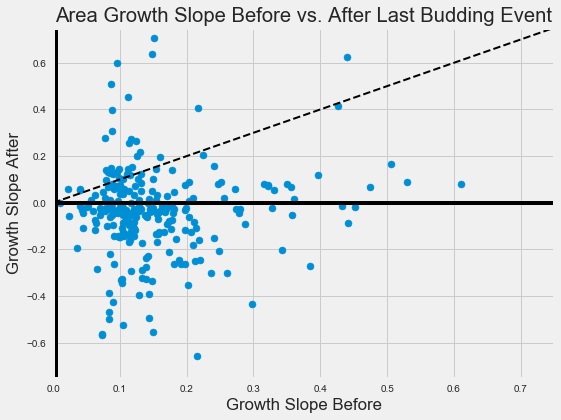

In [333]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(lin_data49['pre-slope'], lin_data49['post-slope'])
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Area Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=0.75)
plt.ylim(ymin=-0.75, ymax=0.75)
'''
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, .15))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, .15))
'''

ax.axhline(y=0, color='k')
ax.axvline(x=0.005, color='k')
ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)

In [310]:
lin_data49[(lin_data49['post-slope'] < .05) & (lin_data49['pre-slope'] > lin_data49['post-slope'])]

pre-slope  pre-intercept  pre-rvalue     pre-pvalue  pre-stderr  \
pos label                                                                    
441 1       0.121153     424.516430    0.907751   6.424936e-96    0.003548   
442 19      0.065318     511.794296    0.471476   1.840508e-06    0.012807   
443 1       0.091831     605.775506    0.718095   5.462489e-30    0.006652   
444 1       0.128800     491.595303    0.768186   3.687032e-17    0.012002   
445 2       0.106828     669.036978    0.486677   2.843785e-12    0.014253   
    14      0.115891     388.010382    0.989818  2.756150e-160    0.001219   
447 1       0.142545     492.197959    0.601455   5.793089e-21    0.013490   
449 1       0.100876     524.322102    0.948959   2.023198e-52    0.003336   
    2       0.104364     426.932714    0.947688  4.763962e-116    0.002318   
457 2       0.120070     444.126070    0.719447   2.542926e-22    0.010166   
    4       0.145833     483.675949    0.777127   2.364636e-17    0.013372   
    5       0.088728     594.367228    0.668515   2.441379e-13    0.010347   
458 20      0.072060     725.228728    0.786877   2.691335e-19    0.006166   
    22      0.113178     413.525899    0.904362   1.254929e-18    0.007875   
459 6       0.138579     418.463122    0.926969   2.079558e-82    0.004079   
460 2       0.108918     604.589916    0.806363   1.256791e-20    0.008769   
461 2       0.170742     473.253569    0.917854   2.535373e-42    0.007347   
467 3       0.163042     355.033394    0.978167   9.854700e-84    0.003162   
    4       0.214357     371.357184    0.895388   4.228385e-52    0.008915   
469 1       0.088445     511.390324    0.869617   1.341281e-70    0.003355   
470 15      0.085704     554.287843    0.810332   5.855112e-13    0.008854   
    20      0.892266     237.843823    0.792750   5.226953e-18    0.078697   
472 1       0.210687     379.216013    0.966414   1.479498e-65    0.005391   
473 2       0.156831     713.311612    0.852968   1.282983e-45    0.007709   
474 9       0.102660     507.435431    0.548642   3.130788e-08    0.016869   
476 1       0.116360     466.874762    0.754887   2.811527e-50    0.006222   
477 2       0.101826     558.890223    0.579320   1.729703e-20    0.009863   
478 1       0.116022     597.374029    0.646416   2.126717e-18    0.011492   
    22      0.123186     389.952291    0.964072   1.148258e-72    0.003061   
    53      0.384499     280.772727    0.973419   9.995002e-08    0.028608   
...              ...            ...         ...            ...         ...   
637 1       0.140398     444.995215    0.956661   4.693305e-72    0.003734   
    2       0.174358     341.681597    0.823855   1.129753e-20    0.013670   
    3       0.091005     515.615755    0.650349   9.251271e-20    0.008650   
638 1       0.105471     690.197538    0.927239   1.372519e-37    0.004647   
    8       0.010843     526.211912    0.683724   2.781447e-30    0.000802   
    11      0.097805    1019.793632    0.903500   1.406153e-38    0.004640   
    35      0.173835     291.519164    0.937195   6.733798e-20    0.010230   
639 1       0.062703     568.171161    0.975803  1.905506e-162    0.000901   
640 22      0.343042     299.530242    0.630851   1.766264e-21    0.031536   
641 1       0.043656     650.602740    0.191647   1.018927e-01    0.026348   
642 13      0.358321     686.224490    0.477105   4.597489e-04    0.095269   
    14      0.198068     309.099651    0.608830   2.690595e-17    0.020730   
643 2       0.129277     750.343628    0.468609   1.126018e-07    0.022825   
644 8       0.073771    1098.261308    0.366997   8.309468e-09    0.012329   
645 16      0.074656     523.448718    0.915111   3.496595e-47    0.003067   
646 1       0.091474     593.436100    0.813468   3.531407e-58    0.004230   
647 1       0.102506     500.063960    0.850927   1.367563e-28    0.006458   
    2       0.133656     379.228122    0.954195   1.552019e-91    0.003205   
648 2       0.109929     466.9335

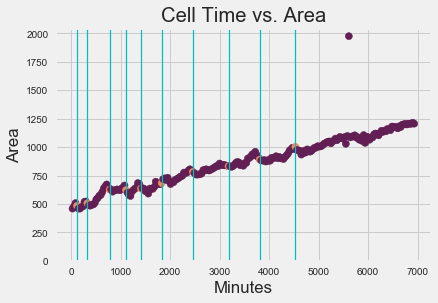

In [292]:
index = (gen_info49['pos']==613) & (gen_info49['label']==6)
plt.xlabel('Minutes')
plt.ylabel('Area')
plt.title('Cell Time vs. Area')
plt.scatter(gen_info49[index]['min'], gen_info49[index]['area'], marker='o', c=gen_info49[index]['state_int'], vmin=-.5, vmax=1.5)
plt.gca().set_ylim(ymin=0)

budding_events = gen_info49[index & (gen_info49['state_int']==1)]['min']
for x in budding_events:
    plt.axvline(x, c='c', linewidth = 1.25)


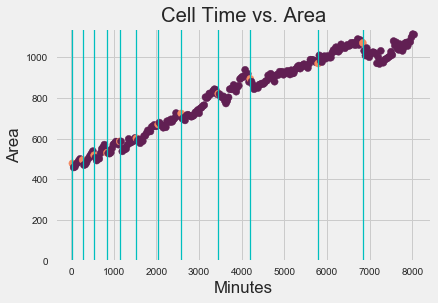

In [302]:
index = (gen_info49['pos']==646) & (gen_info49['label']==3)
plt.xlabel('Minutes')
plt.ylabel('Area')
plt.title('Cell Time vs. Area')
plt.scatter(gen_info49[index]['min'], gen_info49[index]['area'], marker='o', c=gen_info49[index]['state_int'], vmin=-.5, vmax=1.5)
plt.gca().set_ylim(ymin=0)

budding_events = gen_info49[index & (gen_info49['state_int']==1)]['min']
for x in budding_events:
    plt.axvline(x, c='c', linewidth = 1.25)


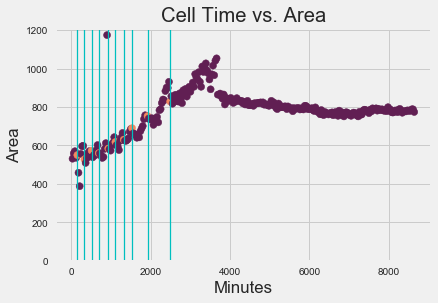

In [312]:
index = (gen_info49['pos']==444) & (gen_info49['label']==1)
plt.xlabel('Minutes')
plt.ylabel('Area')
plt.title('Cell Time vs. Area')
plt.scatter(gen_info49[index]['min'], gen_info49[index]['area'], marker='o', c=gen_info49[index]['state_int'], vmin=-.5, vmax=1.5)
plt.gca().set_ylim(ymin=0)

budding_events = gen_info49[index & (gen_info49['state_int']==1)]['min']
for x in budding_events:
    plt.axvline(x, c='c', linewidth = 1.25)


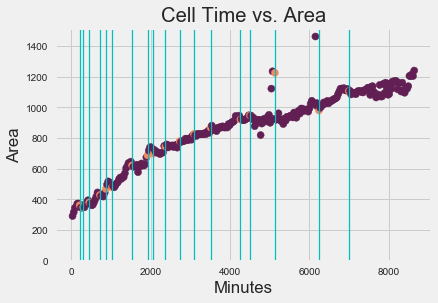

In [317]:
index = (gen_info49['pos']==449) & (gen_info49['label']==2)
plt.xlabel('Minutes')
plt.ylabel('Area')
plt.title('Cell Time vs. Area')
plt.scatter(gen_info49[index]['min'], gen_info49[index]['area'], marker='o', c=gen_info49[index]['state_int'], vmin=-.5, vmax=1.5)
plt.gca().set_ylim(ymin=0)

budding_events = gen_info49[index & (gen_info49['state_int']==1)]['min']
for x in budding_events:
    plt.axvline(x, c='c', linewidth = 1.25)


## Comparing area growth between long-lived and short-lived cells

(367.7937818116021, 1000)

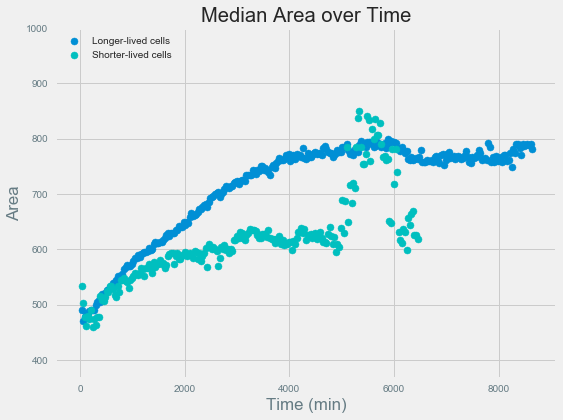

In [111]:
lifespans49_long = gen_info49.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() >= 6500)
med_lifespans49_long = lifespans49_long.groupby(by='min')['area'].median().reset_index()

lifespans49_short = gen_info49.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() < 6500)
med_lifespans49_short = lifespans49_short.groupby(by='min')['area'].median().reset_index()

plt.figure(figsize=(8, 6))
plt.scatter(med_lifespans49_long['min'], med_lifespans49_long['area'], marker='o', label='Longer-lived cells')
plt.scatter(med_lifespans49_short['min'], med_lifespans49_short['area'], marker='o', c='c', label='Shorter-lived cells')
plt.xlabel('Time (min)')
plt.ylabel('Area')
plt.legend(loc = 'upper left')
plt.title('Median Area over Time')

plt.ylim(ymax=1000)

## When Most Divisions Occur vs. Lifespan

In [91]:
total_gens49 = gen_info49.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
total_gens49.rename(columns={'state_int':'gens'}, inplace=True)

first_half_gens49 = gen_info49.groupby(by=['pos', 'label']).apply(lambda x: x[x['min'] <= x['min'].max()/2])
first_half_gens49.drop(['pos', 'label'], axis=1, inplace=True)
first_half_gens49.reset_index(inplace=True)
first_half_gens49 = first_half_gens49.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
first_half_gens49 = first_half_gens49.rename(columns={'state_int':'first_half_gens49'})
first_half_gens49 = pd.merge(first_half_gens49, total_gens49, on=['pos', 'label'], how='outer')
first_half_gens49['first half/total'] = first_half_gens49['first_half_gens49'] / first_half_gens49['gens']
first_half_gens49 = pd.merge(first_half_gens49, lifespans49, on=['pos', 'label'], how='outer')
first_half_gens49 = first_half_gens49.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

final_area_change49 = gen_info49.groupby(by=['pos', 'label'])['area_change'].last().reset_index()

Text(0,0.5,'Final Area of Cell')

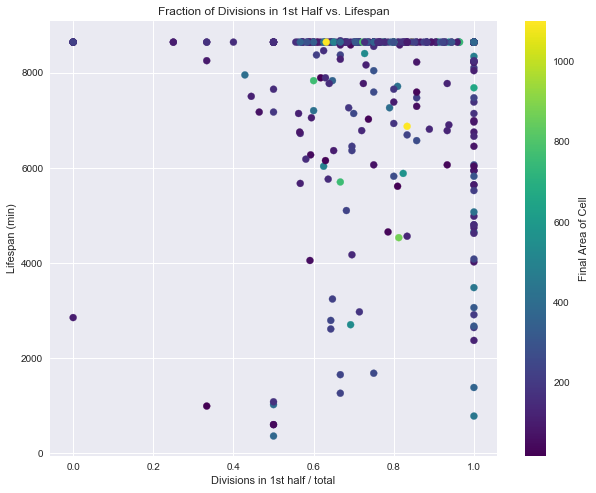

In [92]:
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=final_area_change['area_change'].min(), vmax=1100)

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(first_half_gens49['first half/total'], first_half_gens49['lifespan'], c=cmap(norm(final_area_change49['area_change'].values)))
plt.xlabel('Divisions in 1st half / total')
plt.ylabel('Lifespan (min)')
plt.title('Fraction of Divisions in 1st Half vs. Lifespan')
plt.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Final Area of Cell', rotation=90)


## Linear Regression on 2nd Half of Lifespan

In [38]:
sec_half_gens49 = gen_info49.groupby(by=['pos', 'label']).apply(lambda x: x[x['min'] >= x['min'].max()/2])
sec_half_gens49.drop(['pos', 'label', 'time', 'state', 'id'], axis=1, inplace=True)
sec_half_gens49.reset_index(inplace=True)

lin_data49 = (sec_half_gens49.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'slope',
                        1: 'intercept',
                        2: 'rvalue',
                        3: 'pvalue',
                        4: 'stderr'
                      })
       )

lin_data49 = pd.merge(lin_data49, lifespans49, on=['pos', 'label'], how='outer')
lin_data49.dropna(axis=0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:119: RuntimeWarning: invalid value enco

Text(0.5,1,'Slope vs. Lifespan')

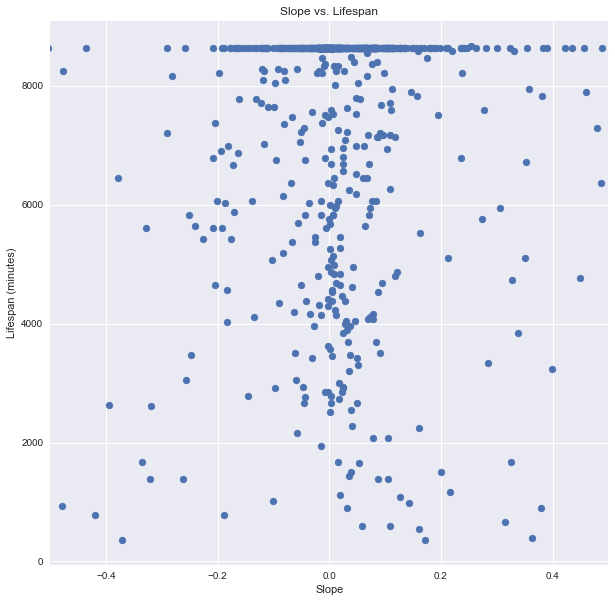

In [45]:
plt.figure(figsize=(10, 10))
plt.scatter(lin_data49['slope'], lin_data49['lifespan'])
plt.xlim(xmin=-.5, xmax=.5)
plt.ylabel('Lifespan (minutes)')
plt.xlabel('Slope')
plt.title('Slope vs. Lifespan')

In [46]:
len(lin_data49[(lin_data49['slope'] >= 0) & (lin_data49['lifespan'] >= 8000)])

284

In [47]:
len(lin_data49[(lin_data49['slope'] < 0) & (lin_data49['lifespan'] >= 8000)])

185

## Initial cell size vs. Lifespan

In [193]:
init_data49 = gen_info49.groupby(by=['pos', 'label']).first()
init_data49.reset_index(inplace=True)

init_data49 = pd.merge(init_data49, lifespans49, on=['pos', 'label'], how='outer')
init_data49.rename(columns={'area':'init_area'}, inplace=True)
init_data49['final_area'] = gen_info49.groupby(by=['pos', 'label'])['area'].last().reset_index()['area']

mean_init_data49 = init_data49.groupby(pd.cut(init_data49['init_area'], np.arange(0, 3500, 100)))['init_area', 'lifespan', 'final_area'].mean()
mean_init_data49.dropna(axis=0, inplace=True)
len(mean_init_data49)

19

Text(0.5,1,'Initial Cell Area vs Mean Lifespan')

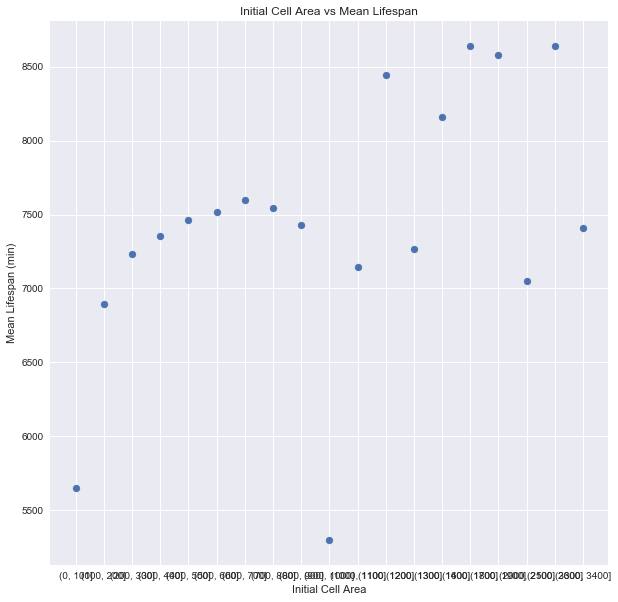

In [7]:

plt.figure(figsize=(10, 10))
plt.scatter(np.linspace(0, 3500, 19), mean_init_data49.lifespan)
plt.xticks(np.linspace(0, 3500, 19), mean_init_data49.index)
#plt.ylim(ymin=0)
plt.xlabel('Initial Cell Area')
plt.ylabel('Mean Lifespan (min)')
plt.title('Initial Cell Area vs Mean Lifespan')
 


Text(0.5,1,'Initial Cell Area vs. Lifespan')

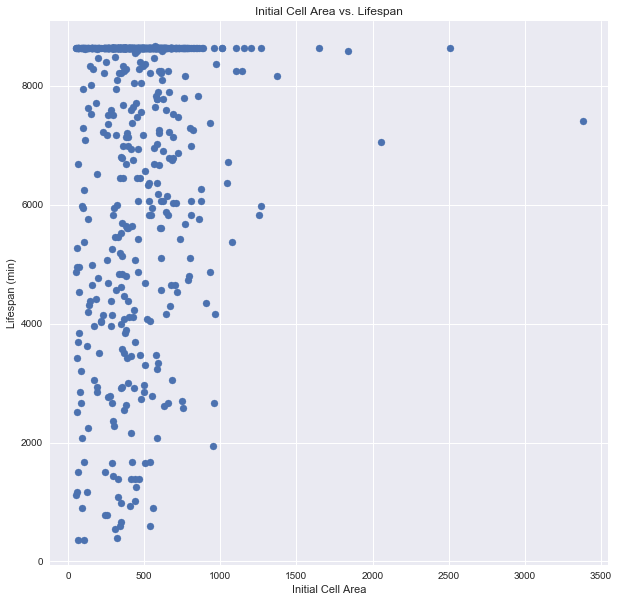

In [206]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plt.scatter(init_data49['init_area'], init_data49['lifespan'])
plt.xlabel('Initial Cell Area')
plt.ylabel('Lifespan (min)')
plt.title('Initial Cell Area vs. Lifespan')


# Exp 56

In [2]:
gen_info56 = pd.read_table('LifeSpanCellFeatures/exp56_changhui.txt', sep='\t')
gen_info56.sort_values(by=['pos', 'label', 'time'], ascending=True, inplace=True)

gen_info56['state_int'] = 0
gen_info56['state_int'][gen_info56['state']=='S'] = 1
gen_info56.drop(['x', 'y', 'auto_type', 'final_state', 'is_fresh'], axis=1, inplace=True)
gen_info56['gen'] = gen_info56.groupby(by=['pos', 'label']).state_int.cumsum() + 1
gen_info56['id'] = 'P' + gen_info56['pos'].astype(str) + 'L' + gen_info56['label'].astype(str)
gen_info56['min'] = 30 * gen_info56['time']

gen_info56['area_change'] = gen_info56.groupby(by=['pos', 'label'])['area'].apply(lambda x: x.div(x.iloc[0])).multiply(100)
mean_data56 = gen_info56.groupby(by='gen')['area_change'].mean().reset_index()
data_vals56 = gen_info56.pivot_table(index = 'id', columns = 'gen', values = 'area_change')
std_vals56 = data_vals56.std(axis=0)
std_vals56.reset_index(drop=True, inplace=True)

lifespans56 = gen_info56.groupby(by=['pos', 'label'])['min'].max().reset_index().sort_values(by=['min'], ascending=False)
lifespans56.rename(columns={'min':'lifespan'}, inplace=True)
#lifespans56

In [3]:
before_last_gen56 =  gen_info56.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
before_last_gen56.drop(['pos', 'label'], axis=1, inplace=True)

after_last_gen56 = gen_info56.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
mean_after_size56 = int(after_last_gen56.groupby(by=['pos', 'label']).size().mean())
after_last_gen56 = after_last_gen56.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= mean_after_size56)
after_last_gen56.drop(['pos', 'label'], axis=1, inplace=True)

blg56_lin = (before_last_gen56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

alg56_lin = (after_last_gen56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

lin_data56 = pd.merge(blg56_lin, alg56_lin, on=['pos', 'label'], how='outer')
lin_data56 = lin_data56.dropna(axis=0)

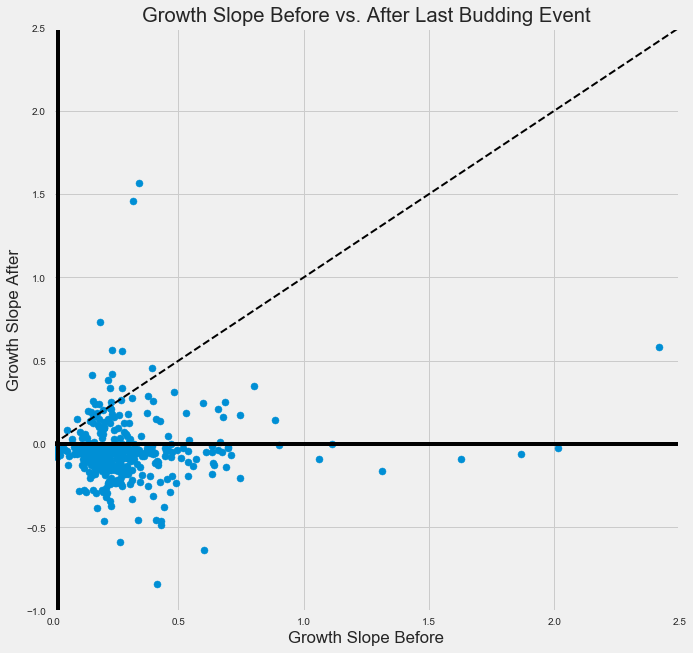

In [236]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(lin_data56['pre-slope'], lin_data56['post-slope'])
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=2.5)
plt.ylim(ymin=-1, ymax=2.5)

ax.axhline(y=0, color='k')
ax.axvline(x=0.02, color='k')
ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)

In [5]:
group1 = lin_data56[lin_data56['pre-slope'] > lin_data56['post-slope']]
group1

pre-slope  pre-intercept  pre-rvalue    pre-pvalue  pre-stderr  \
pos  label                                                                   
1    1       0.146732     736.382353    0.625606  7.231002e-03    0.047244   
     27      0.258918     516.700000    0.878721  1.602314e-07    0.032267   
2    1       0.260876     526.873029    0.958265  5.370414e-48    0.008442   
3    4       0.400725     457.869565    0.835903  6.833972e-07    0.057419   
4    1       0.144108     498.956113    0.946709  4.392994e-44    0.005287   
8    1       0.258474     440.951903    0.869568  1.071225e-15    0.021642   
     8       0.657193     201.200000    0.826411  1.295904e-05    0.108601   
     11      1.866117   -1991.912088    0.522594  6.691164e-02    0.917940   
10   1       0.203165     624.474201    0.989548  2.843812e-73    0.003211   
12   1       0.155754     502.192790    0.956652  7.533923e-48    0.005113   
     8       2.417460   -3179.452381    0.921276  1.148832e-03    0.416622   
46   3       0.470833    -179.696970    0.944187  1.682521e-16    0.029503   
71   12      0.169231     608.625110    0.952767  7.120199e-36    0.006640   
76   1       0.200959     475.846531    0.916681  9.425462e-21    0.012645   
     26      0.200539     539.925000    0.637030  7.955468e-03    0.064854   
77   2       0.260114     466.048433    0.892459  3.995015e-10    0.026297   
78   5       0.191122     558.673813    0.897282  1.047714e-14    0.015459   
79   1       0.183214     411.380984    0.965867  1.936491e-40    0.006048   
     11      0.194269     551.359694    0.948497  4.184442e-25    0.009464   
86   3       0.011157     694.968254    0.042368  8.304956e-01    0.051596   
87   1       0.158338     515.944444    0.769809  1.674861e-06    0.025747   
91   1       0.317174     416.795031    0.826580  1.227572e-18    0.026190   
     4       0.325058     537.030303    0.803968  1.623515e-03    0.076033   
     12      0.151014     567.014801    0.886147  1.233440e-16    0.011772   
95   1       0.126839     353.541725    0.977799  3.701518e-45    0.003398   
     2       0.204353     464.325253    0.958938  1.121919e-30    0.008302   
96   1       0.159984     518.886111    0.947878  5.424282e-41    0.006051   
     2       0.185861     640.538462    0.650067  1.184327e-02    0.062717   
97   5       0.142538     549.731359    0.967142  1.587083e-53    0.004017   
98   3       0.128775     508.427239    0.888838  1.784526e-27    0.007615   
...               ...            ...         ...           ...         ...   
1142 1       0.293806     513.432459    0.943677  4.814639e-44    0.010981   
1148 16      0.314628     495.157764    0.738698  5.235385e-15    0.032506   
1150 22      0.063387     550.990447    0.264153  9.513969e-02    0.037060   
     55      0.038475     627.384440    0.196021  1.147026e-01    0.024059   
     62      0.287151     409.592248    0.849543  9.467360e-18    0.023413   
2490 2       0.387375     566.653595    0.655550  3.141325e-03    0.111558   
     19      0.139310     497.620690    0.802217  1.667017e-07    0.019953   
2509 11      0.159684     541.156863    0.678082  1.982525e-03    0.043271   
2511 29      0.242311     409.720721    0.867636  3.658333e-12    0.023471   
2515 1       0.206845     458.682984    0.762100  5.324597e-16    0.020158   
2516 17      0.691880     298.289855    0.919487  1.868969e-19    0.044595   
2517 3       0.076129     488.974098    0.771411  2.215642e-10    0.009362   
     6       0.173347     495.637820    0.876482  1.575541e-16    0.013889   
2519 30      0.165171     478.573669    0.980840  1.315987e-53    0.003840   
2521 29      0.706621     395.327704    0.782904  3.442245e-14    0.071896   
2522 1       0.251375     597.932432    0.613015  5.493928e-05    0.054762   
     36      0.335674     616.408842    0.753285  2.280870e-14    0.035030   
2525 1       0.290510     823.716384    0.499099  4.924974e-05    0.066230   
     24      0.130814     492.4927

## Comparing area growth between long-lived and short-lived cells

Text(0.5,1,'Median Area over Time')

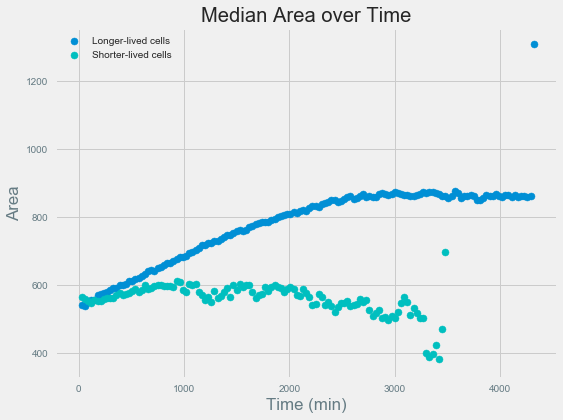

In [95]:
lifespans56_long = gen_info56.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() >= 3500)
med_lifespans56_long = lifespans56_long.groupby(by='min')['area'].median().reset_index()

lifespans56_short = gen_info56.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() < 3500)
med_lifespans56_short = lifespans56_short.groupby(by='min')['area'].median().reset_index()

plt.figure(figsize=(8, 6))
plt.scatter(med_lifespans56_long['min'], med_lifespans56_long['area'], marker='o', label='Longer-lived cells')
plt.scatter(med_lifespans56_short['min'], med_lifespans56_short['area'], marker='o', c='c', label='Shorter-lived cells')
plt.xlabel('Time (min)')
plt.ylabel('Area')
plt.legend(loc = 'upper left')
plt.title('Median Area over Time')

## When Most Divisions Occur vs. Lifespan

In [78]:
total_gens56 = gen_info56.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
total_gens56.rename(columns={'state_int':'gens'}, inplace=True)

first_half_gens56 = gen_info56.groupby(by=['pos', 'label']).apply(lambda x: x[x['min'] <= x['min'].max()/2])
first_half_gens56.drop(['pos', 'label'], axis=1, inplace=True)
first_half_gens56.reset_index(inplace=True)
first_half_gens56 = first_half_gens56.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
first_half_gens56 = first_half_gens56.rename(columns={'state_int':'first_half_gens56'})
first_half_gens56 = pd.merge(first_half_gens56, total_gens56, on=['pos', 'label'], how='outer')
first_half_gens56['first half/total'] = first_half_gens56['first_half_gens56'] / first_half_gens56['gens']
first_half_gens56 = pd.merge(first_half_gens56, lifespans56, on=['pos', 'label'], how='outer')
first_half_gens56 = first_half_gens56.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

final_area_change56 = gen_info56.groupby(by=['pos', 'label'])['area_change'].last().reset_index()

Text(0,0.5,'Final Area of Cell')

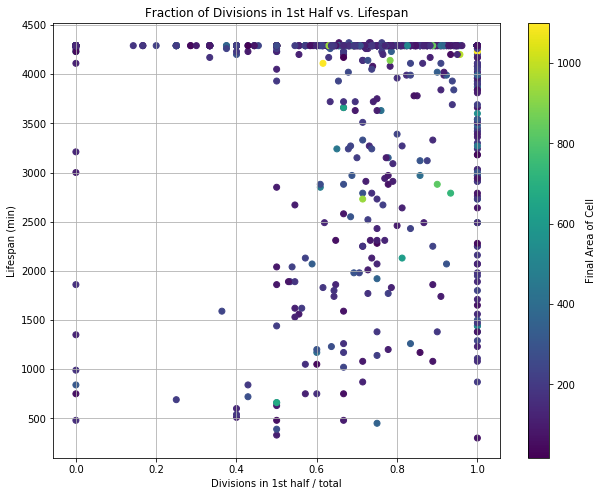

In [79]:
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=final_area_change['area_change'].min(), vmax=1100)

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(first_half_gens56['first half/total'], first_half_gens56['lifespan'], c=cmap(norm(final_area_change56['area_change'].values)))
plt.xlabel('Divisions in 1st half / total')
plt.ylabel('Lifespan (min)')
plt.title('Fraction of Divisions in 1st Half vs. Lifespan')
plt.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Final Area of Cell', rotation=90)


## Linear Regression on 2nd Half of Lifespan

In [71]:
sec_half_gens56 = gen_info56.groupby(by=['pos', 'label']).apply(lambda x: x[x['min'] >= x['min'].max()/2])
sec_half_gens56.drop(['pos', 'label', 'time', 'state', 'id'], axis=1, inplace=True)
sec_half_gens56.reset_index(inplace=True)

lin_data56 = (sec_half_gens56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'slope',
                        1: 'intercept',
                        2: 'rvalue',
                        3: 'pvalue',
                        4: 'stderr'
                      })
       )

lin_data56 = pd.merge(lin_data56, lifespans56, on=['pos', 'label'], how='outer')
lin_data56.dropna(axis=0, inplace=True)

Text(0.5,1,'Slope vs. Lifespan')

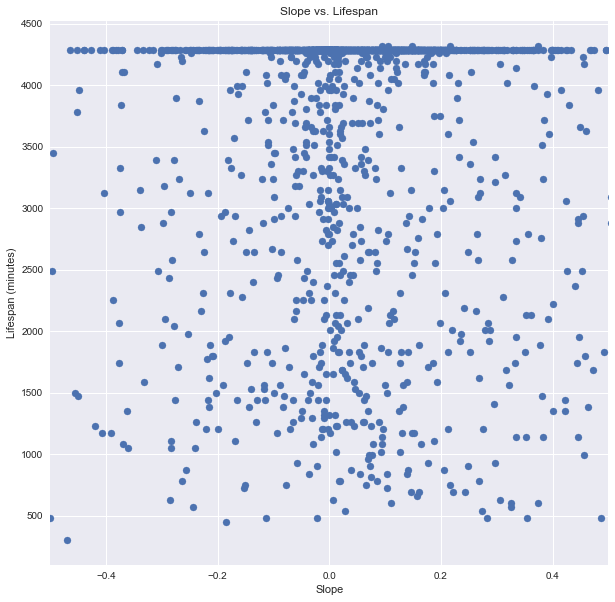

In [52]:
plt.figure(figsize=(10, 10))
plt.scatter(lin_data56['slope'], lin_data56['lifespan'])
plt.xlim(xmin=-.5, xmax=.5)
plt.ylabel('Lifespan (minutes)')
plt.xlabel('Slope')
plt.title('Slope vs. Lifespan')

In [55]:
len(lin_data56[(lin_data56['slope'] >= 0) & (lin_data56['lifespan'] >= 3500)])

955

In [54]:
len(lin_data56[(lin_data56['slope'] < 0) & (lin_data56['lifespan'] >= 3500)])

575

In [96]:
len(lin_data56[(lin_data56['slope'] > 0)])

1291

In [95]:
len(lin_data56[(lin_data56['slope'] < 0)])

808

## Initial cell size vs. Lifespan

In [192]:
init_data56 = gen_info56.groupby(by=['pos', 'label']).first()
init_data56.reset_index(inplace=True)

init_data56 = pd.merge(init_data56, lifespans56, on=['pos', 'label'], how='outer')
init_data56.rename(columns={'area':'init_area'}, inplace=True)
init_data56['final_area'] = gen_info56.groupby(by=['pos', 'label'])['area'].last().reset_index()['area']

mean_init_data56 = init_data56.groupby(pd.cut(init_data56['init_area'], np.arange(0, 3200, 150)))['init_area', 'lifespan', 'final_area'].mean()
mean_init_data56.dropna(axis=0, inplace=True)
len(mean_init_data56)

19

Text(0.5,1,'Initial Cell Area vs Mean Lifespan')

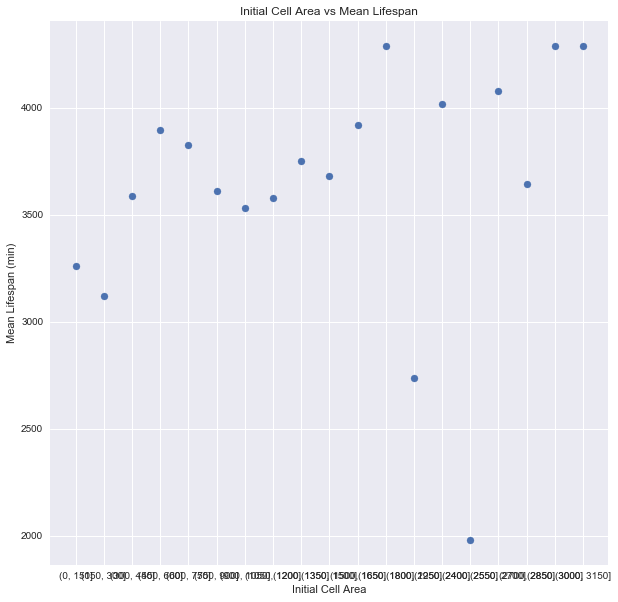

In [10]:

plt.figure(figsize=(10, 10))
plt.scatter(np.linspace(0, 3500, 19), mean_init_data56.lifespan)
plt.xticks(np.linspace(0, 3500, 19), mean_init_data56.index)
#plt.ylim(ymin=0)
plt.xlabel('Initial Cell Area')
plt.ylabel('Mean Lifespan (min)')
plt.title('Initial Cell Area vs Mean Lifespan')


Text(0.5,1,'Initial Cell Area vs. Lifespan')

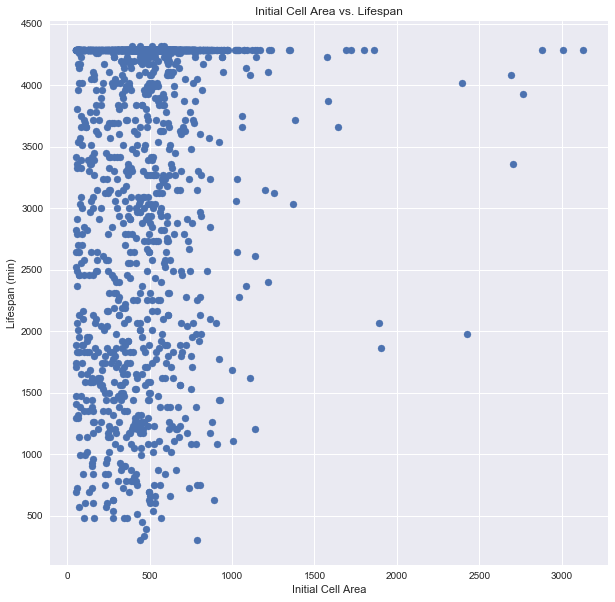

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plt.scatter(init_data56['init_area'], init_data56['lifespan'])
plt.xlabel('Initial Cell Area')
plt.ylabel('Lifespan (min)')
plt.title('Initial Cell Area vs. Lifespan')


In [232]:
median_data = init_data.groupby(pd.cut(init_data['init_area'], np.arange(0, 3200, 150)))['init_area', 'lifespan', 'final_area']
median_data.median()

,init_area,lifespan,final_area
init_area,,,
"(0, 150]",95.0,3480.0,277.0
"(150, 300]",234.0,2460.0,335.0
"(300, 450]",379.0,4260.0,608.0
"(450, 600]",521.0,4260.0,872.0
"(600, 750]",655.0,4260.0,912.0
"(750, 900]",787.5,4260.0,757.5
"(900, 1050]",944.5,4260.0,1339.0
"(1050, 1200]",1137.5,3705.0,1781.0
"(1200, 1350]",NaN,NaN,NaN


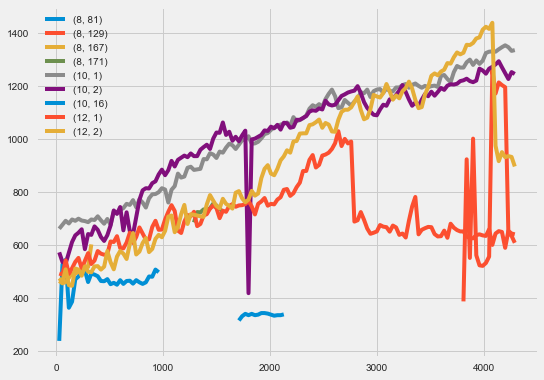

In [140]:
grouped_sample56 = gen_info56[(gen_info56.groupby(by=['pos', 'label']).ngroup() > 20) & (gen_info56.groupby(by=['pos', 'label']).ngroup() < 30)].groupby(by=['pos', 'label'])

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
for tag, group in grouped_sample56:
    plt.plot(group['min'], group['area'], label=tag)
    
plt.legend(loc='upper left')

# Exp 92

In [6]:
gen_info92 = pd.read_table('LifeSpanCellFeatures/exp92_changhui.txt', sep='\t')
gen_info92.sort_values(by=['pos', 'label', 'time'], ascending=True, inplace=True)

gen_info92['state_int'] = 0
gen_info92['state_int'][gen_info92['state']=='S'] = 1
gen_info92.drop(['x', 'y', 'auto_type', 'final_state', 'is_fresh'], axis=1, inplace=True)
gen_info92['gen'] = gen_info92.groupby(by=['pos', 'label']).state_int.cumsum() + 1
gen_info92['id'] = 'P' + gen_info92['pos'].astype(str) + 'L' + gen_info92['label'].astype(str)
gen_info92['min'] = 30 * gen_info92['time']

gen_info92['area_change'] = gen_info92.groupby(by=['pos', 'label'])['area'].apply(lambda x: x.div(x.iloc[0])).multiply(100)
mean_data92 = gen_info92.groupby(by='gen')['area_change'].mean().reset_index()
data_vals92 = gen_info92.pivot_table(index = 'id', columns = 'gen', values = 'area_change')
std_vals92 = data_vals92.std(axis=0)
std_vals92.reset_index(drop=True, inplace=True)

lifespans92 = gen_info92.groupby(by=['pos', 'label'])['min'].max().reset_index().sort_values(by=['min'], ascending=False)
lifespans92.rename(columns={'min':'lifespan'}, inplace=True)
#lifespans92

In [7]:
before_last_gen92 =  gen_info92.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
before_last_gen92.drop(['pos', 'label'], axis=1, inplace=True)

after_last_gen92 = gen_info92.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
mean_after_size92 = int(after_last_gen92.groupby(by=['pos', 'label']).size().mean())
after_last_gen92 = after_last_gen92.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= mean_after_size92)
after_last_gen92.drop(['pos', 'label'], axis=1, inplace=True)

blg92_lin = (before_last_gen92.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

alg92_lin = (after_last_gen92.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

lin_data92 = pd.merge(blg92_lin, alg92_lin, on=['pos', 'label'], how='outer')
lin_data92 = lin_data92.dropna(axis=0)

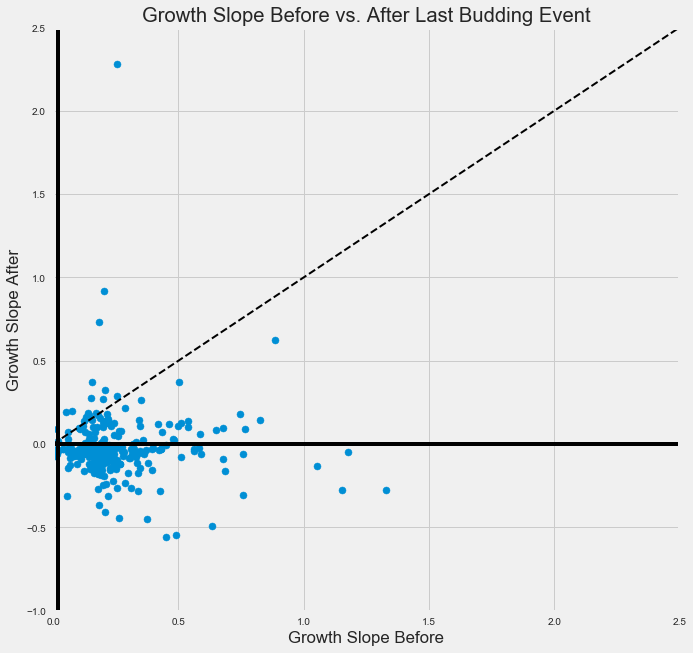

In [238]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(lin_data92['pre-slope'], lin_data92['post-slope'])
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=2.5)
plt.ylim(ymin=-1, ymax=2.5)

ax.axhline(y=0, color='k')
ax.axvline(x=0.02, color='k')
ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)

## Comparing area growth between long-lived and short-lived cells

Text(0.5,1,'Median Area over Time')

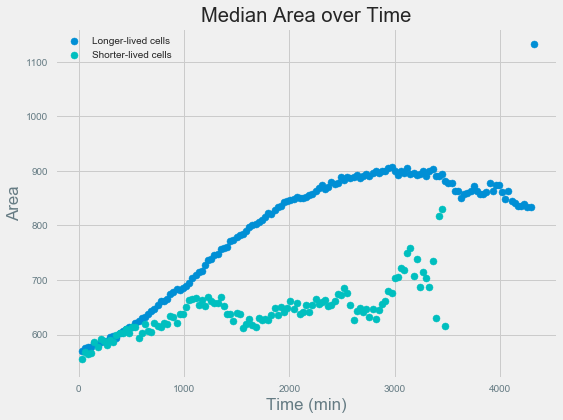

In [92]:
lifespans92_long = gen_info92.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() >= 3500)
med_lifespans92_long = lifespans92_long.groupby(by='min')['area'].median().reset_index()

lifespans92_short = gen_info92.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() < 3500)
med_lifespans92_short = lifespans92_short.groupby(by='min')['area'].median().reset_index()

plt.figure(figsize=(8, 6))
plt.scatter(med_lifespans92_long['min'], med_lifespans92_long['area'], marker='o', label='Longer-lived cells')
plt.scatter(med_lifespans92_short['min'], med_lifespans92_short['area'], marker='o', c='c', label='Shorter-lived cells')
plt.xlabel('Time (min)')
plt.ylabel('Area')
plt.legend(loc = 'upper left')
plt.title('Median Area over Time')

## When Most Divisions Occur vs. Lifespan

In [66]:
total_gens92 = gen_info92.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
total_gens92.rename(columns={'state_int':'gens'}, inplace=True)

first_half_gens92 = gen_info92.groupby(by=['pos', 'label']).apply(lambda x: x[x['min'] <= x['min'].max()/2])
first_half_gens92.drop(['pos', 'label'], axis=1, inplace=True)
first_half_gens92.reset_index(inplace=True)
first_half_gens92 = first_half_gens92.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
first_half_gens92 = first_half_gens92.rename(columns={'state_int':'first_half_gens92'})
first_half_gens92 = pd.merge(first_half_gens92, total_gens92, on=['pos', 'label'], how='outer')
first_half_gens92['first half/total'] = first_half_gens92['first_half_gens92'] / first_half_gens92['gens']
first_half_gens92 = pd.merge(first_half_gens92, lifespans92, on=['pos', 'label'], how='outer')
first_half_gens92 = first_half_gens92.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

final_area_change92 = gen_info92.groupby(by=['pos', 'label'])['area_change'].last().reset_index()

Text(0,0.5,'Final Area of Cell')

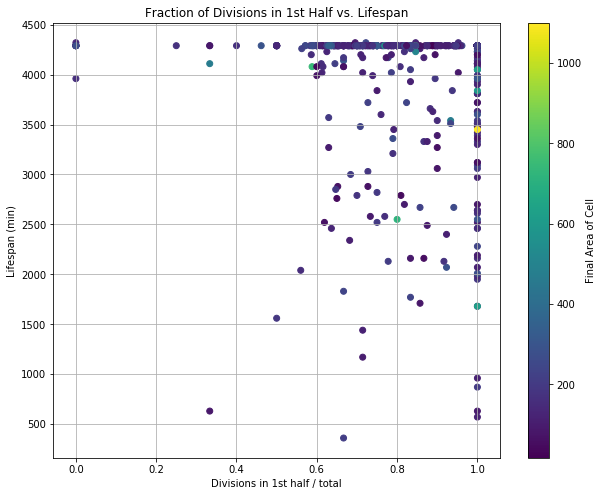

In [67]:
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=final_area_change['area_change'].min(), vmax=1100)

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(first_half_gens92['first half/total'], first_half_gens92['lifespan'], c=cmap(norm(final_area_change92['area_change'].values)))
plt.xlabel('Divisions in 1st half / total')
plt.ylabel('Lifespan (min)')
plt.title('Fraction of Divisions in 1st Half vs. Lifespan')
plt.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Final Area of Cell', rotation=90)


## Initial Cell Size vs Lifespan

In [190]:
init_data92 = gen_info92.groupby(by=['pos', 'label']).first()
init_data92.reset_index(inplace=True)

init_data92 = pd.merge(init_data92, lifespans92, on=['pos', 'label'], how='outer')
init_data92.rename(columns={'area':'init_area'}, inplace=True)
init_data92['final_area'] = gen_info92.groupby(by=['pos', 'label'])['area'].last().reset_index()['area']

mean_init_data92 = init_data92.groupby(pd.cut(init_data92['init_area'], np.arange(0, 3500, 100)))['init_area', 'lifespan', 'final_area'].mean()
mean_init_data92.dropna(axis=0, inplace=True)
len(mean_init_data92)

17

Text(0.5,1,'Initial Cell Area vs Mean Lifespan')

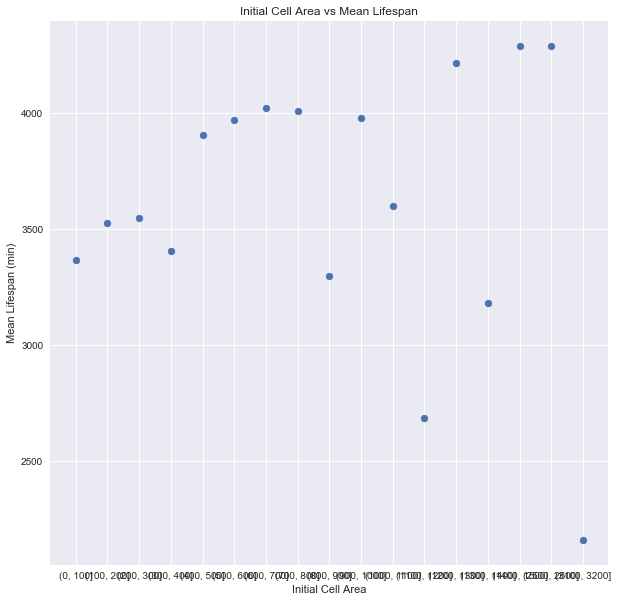

In [13]:

plt.figure(figsize=(10, 10))
plt.scatter(np.linspace(0, 3500, 17), mean_init_data92.lifespan)
plt.xticks(np.linspace(0, 3500, 17), mean_init_data92.index)
#plt.ylim(ymin=0)
plt.xlabel('Initial Cell Area')
plt.ylabel('Mean Lifespan (min)')
plt.title('Initial Cell Area vs Mean Lifespan')


# Exp 95

In [8]:
gen_info95 = pd.read_table('LifeSpanCellFeatures/exp95_changhui.txt', sep='\t')
gen_info95.sort_values(by=['pos', 'label', 'time'], ascending=True, inplace=True)

gen_info95['state_int'] = 0
gen_info95['state_int'][gen_info95['state']=='S'] = 1
gen_info95.drop(['x', 'y', 'auto_type', 'final_state', 'is_fresh'], axis=1, inplace=True)
gen_info95['gen'] = gen_info95.groupby(by=['pos', 'label']).state_int.cumsum() + 1
gen_info95['id'] = 'P' + gen_info95['pos'].astype(str) + 'L' + gen_info95['label'].astype(str)
gen_info95['min'] = 30 * gen_info95['time']

gen_info95['area_change'] = gen_info95.groupby(by=['pos', 'label'])['area'].apply(lambda x: x.div(x.iloc[0])).multiply(100)
mean_data95 = gen_info95.groupby(by='gen')['area_change'].mean().reset_index()
data_vals95 = gen_info95.pivot_table(index = 'id', columns = 'gen', values = 'area_change')
std_vals95 = data_vals95.std(axis=0)
std_vals95.reset_index(drop=True, inplace=True)

lifespans95 = gen_info95.groupby(by=['pos', 'label'])['min'].max().reset_index().sort_values(by=['min'], ascending=False)
lifespans95.rename(columns={'min':'lifespan'}, inplace=True)
#lifespans95

In [9]:
before_last_gen95 =  gen_info95.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
before_last_gen95.drop(['pos', 'label'], axis=1, inplace=True)

after_last_gen95 = gen_info95.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
mean_after_size95 = int(after_last_gen95.groupby(by=['pos', 'label']).size().mean())
after_last_gen95 = after_last_gen95.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= mean_after_size95)
after_last_gen95.drop(['pos', 'label'], axis=1, inplace=True)

blg95_lin = (before_last_gen95.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

alg95_lin = (after_last_gen95.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

lin_data95 = pd.merge(blg95_lin, alg95_lin, on=['pos', 'label'], how='outer')
lin_data95 = lin_data95.dropna(axis=0)

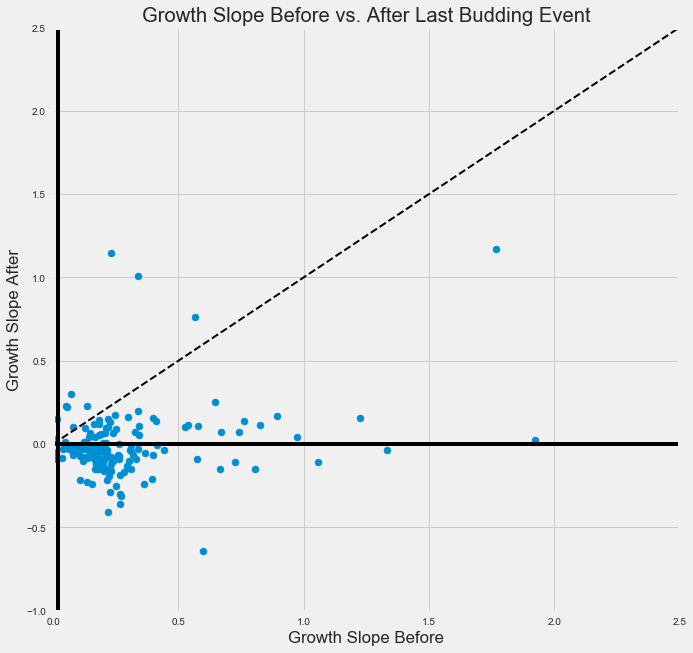

In [240]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(lin_data95['pre-slope'], lin_data95['post-slope'])
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=2.5)
plt.ylim(ymin=-1, ymax=2.5)

ax.axhline(y=0, color='k')
ax.axvline(x=0.02, color='k')
ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)

## Comparing area growth between long-lived and short-lived cells

Text(0.5,1,'Median Area over Time')

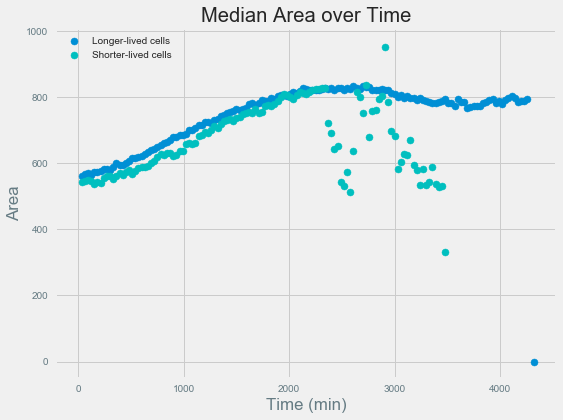

In [93]:
lifespans95_long = gen_info95.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() >= 3500)
med_lifespans95_long = lifespans95_long.groupby(by='min')['area'].median().reset_index()

lifespans95_short = gen_info95.groupby(by=['pos', 'label']).filter(lambda x: x['min'].max() < 3500)
med_lifespans95_short = lifespans95_short.groupby(by='min')['area'].median().reset_index()

plt.figure(figsize=(8, 6))
plt.scatter(med_lifespans95_long['min'], med_lifespans95_long['area'], marker='o', label='Longer-lived cells')
plt.scatter(med_lifespans95_short['min'], med_lifespans95_short['area'], marker='o', c='c', label='Shorter-lived cells')
plt.xlabel('Time (min)')
plt.ylabel('Area')
plt.legend(loc = 'upper left')
plt.title('Median Area over Time')

## When Most Divisions Occur vs. Lifespan

In [62]:
total_gens95 = gen_info95.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
total_gens95.rename(columns={'state_int':'gens'}, inplace=True)

first_half_gens95 = gen_info95.groupby(by=['pos', 'label']).apply(lambda x: x[x['min'] <= x['min'].max()/2])
first_half_gens95.drop(['pos', 'label'], axis=1, inplace=True)
first_half_gens95.reset_index(inplace=True)
first_half_gens95 = first_half_gens95.groupby(by=['pos', 'label'])['state_int'].sum().reset_index()
first_half_gens95 = first_half_gens95.rename(columns={'state_int':'first_half_gens95'})
first_half_gens95 = pd.merge(first_half_gens95, total_gens95, on=['pos', 'label'], how='outer')
first_half_gens95['first half/total'] = first_half_gens95['first_half_gens95'] / first_half_gens95['gens']
first_half_gens95 = pd.merge(first_half_gens95, lifespans95, on=['pos', 'label'], how='outer')
first_half_gens95 = first_half_gens95.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

final_area_change95 = gen_info95.groupby(by=['pos', 'label'])['area_change'].last().reset_index()

Text(0,0.5,'Final Area of Cell')

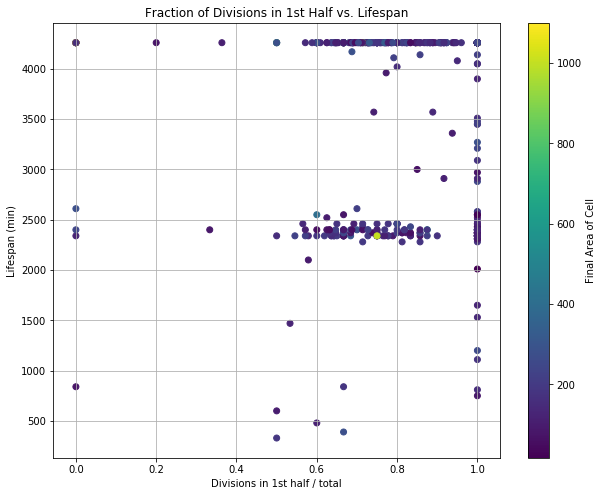

In [63]:
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=final_area_change['area_change'].min(), vmax=1100)

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(first_half_gens95['first half/total'], first_half_gens95['lifespan'], c=cmap(norm(final_area_change95['area_change'].values)))
plt.xlabel('Divisions in 1st half / total')
plt.ylabel('Lifespan (min)')
plt.title('Fraction of Divisions in 1st Half vs. Lifespan')
plt.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Final Area of Cell', rotation=90)


## Initial cell size vs. Lifespan

In [187]:
init_data95 = gen_info95.groupby(by=['pos', 'label']).first()
init_data95.reset_index(inplace=True)

init_data95 = pd.merge(init_data95, lifespans95, on=['pos', 'label'], how='outer')
init_data95.rename(columns={'area':'init_area'}, inplace=True)
init_data95['final_area'] = gen_info95.groupby(by=['pos', 'label'])['area'].last().reset_index()['area']

mean_init_data95 = init_data95.groupby(pd.cut(init_data95['init_area'], np.arange(0, 2500, 50)))['init_area', 'lifespan', 'final_area'].mean()
mean_init_data95.dropna(axis=0, inplace=True)
len(mean_init_data95)

24

Text(0.5,1,'Initial Cell Area vs Mean Lifespan')

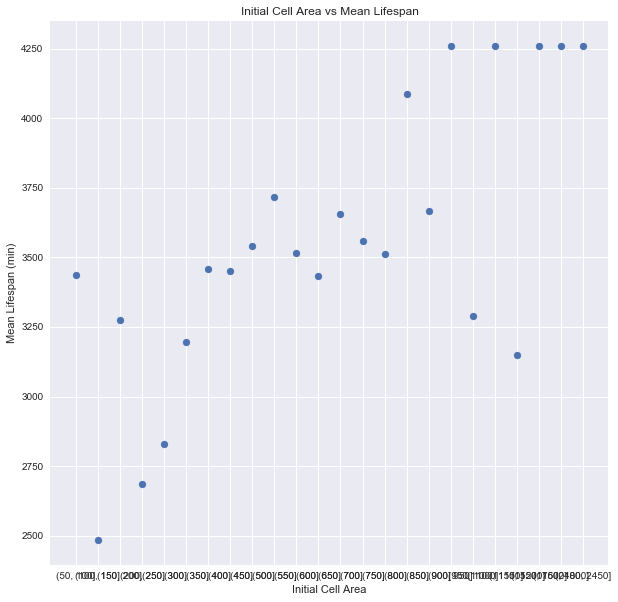

In [17]:

plt.figure(figsize=(10, 10))
plt.scatter(np.linspace(0, 2500, 24), mean_init_data95.lifespan)
plt.xticks(np.linspace(0, 2500, 24), mean_init_data95.index)
#plt.ylim(ymin=0)
plt.xlabel('Initial Cell Area')
plt.ylabel('Mean Lifespan (min)')
plt.title('Initial Cell Area vs Mean Lifespan')
 

Text(0.5,1,'Initial Cell Area vs. Lifespan')

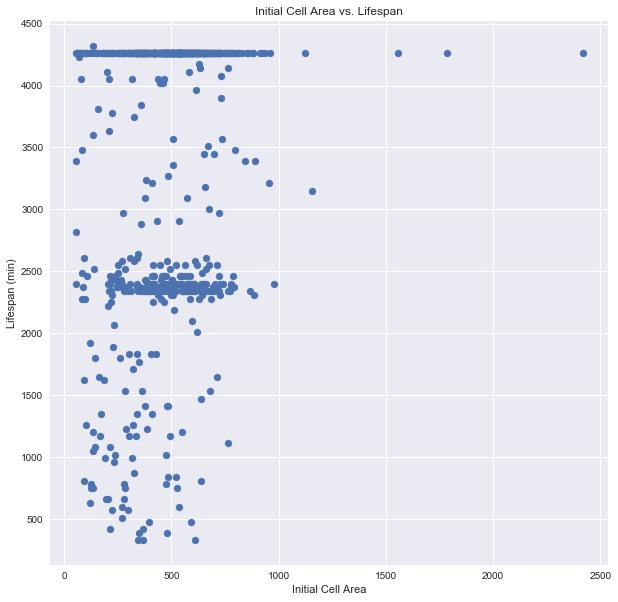

In [223]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plt.scatter(init_data95['init_area'], init_data95['lifespan'])
plt.xlabel('Initial Cell Area')
plt.ylabel('Lifespan (min)')
plt.title('Initial Cell Area vs. Lifespan')


## Number of cells in each dataset

In [93]:
len(gen_info49.groupby(by=['pos', 'label']))

723

In [94]:
len(gen_info56.groupby(by=['pos', 'label']))

2099

In [95]:
len(gen_info92.groupby(by=['pos', 'label']))

855

In [96]:
len(gen_info95.groupby(by=['pos', 'label']))

767

# Aggregation of all datasets

## Initial Cell Area vs. Lifespan

Text(-3,900,'Note: the data have been split into groups by initial cell area of equal ranges (dependent on experiment) and then averaged')

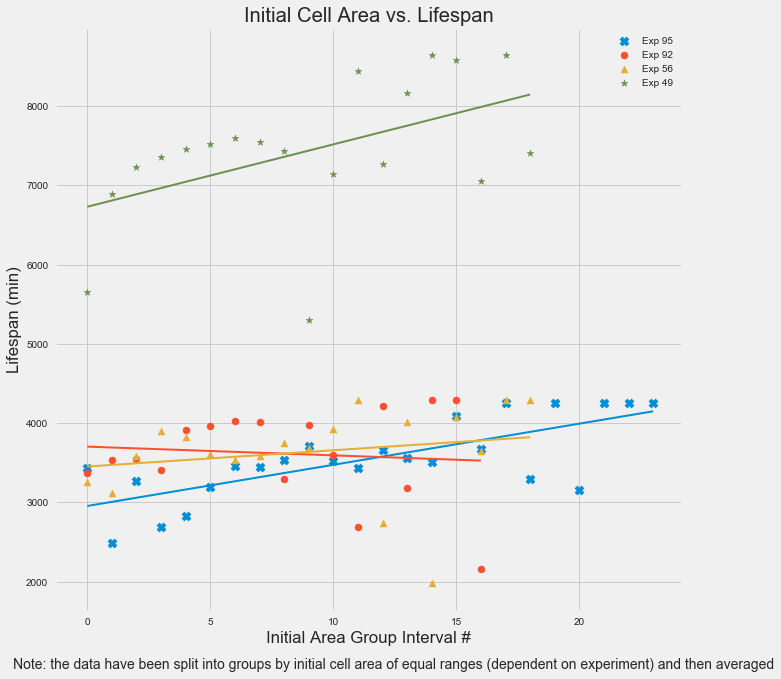

In [256]:
from scipy import stats

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

slopes = []

x95 = range(0, 24)
ax1.scatter(x95, mean_init_data95.lifespan, marker = 'x', label = 'Exp 95')
slope, intercept, r_value, p_value, std_err = stats.linregress(x95, mean_init_data95.lifespan)
slopes.append(slope)
line = slope*x95+intercept
ax1.plot(line, linewidth = 2)

x92 = range(0, 17)
ax1.scatter(x92, mean_init_data92.lifespan, marker = 'o', label = 'Exp 92')
slope, intercept, r_value, p_value, std_err = stats.linregress(x92, mean_init_data92.lifespan)
slopes.append(slope)
line = slope*x92+intercept
ax1.plot(line, linewidth = 2)

x56 = range(0, 19)
ax1.scatter(x56, mean_init_data56.lifespan, marker = '^', label = 'Exp 56')
slope, intercept, r_value, p_value, std_err = stats.linregress(x56, mean_init_data56.lifespan)
slopes.append(slope)
line = slope*x56+intercept
ax1.plot(line, linewidth = 2)

ax1.scatter(x56, mean_init_data49.lifespan, marker = '*', label = 'Exp 49')
slope, intercept, r_value, p_value, std_err = stats.linregress(x56, mean_init_data49.lifespan)
slopes.append(slope)
line = slope*x56+intercept
ax1.plot(line, linewidth = 2)

plt.legend(loc='upper right')
plt.xlabel('Initial Area Group Interval #')
plt.ylabel('Lifespan (min)')
plt.title('Initial Cell Area vs. Lifespan')
plt.text(-3, 900, 'Note: the data have been split into groups by initial cell area of equal ranges (dependent on experiment) and then averaged')


In [258]:
slopes

[51.93042139315605, -11.024292449533306, 20.545380787965012, 78.66729994406563]

## Linear regression on slopes pre vs post last budding

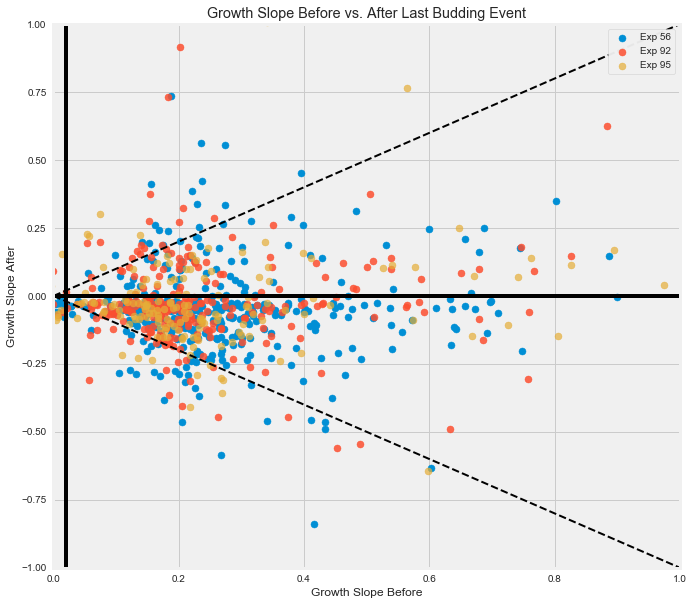

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.scatter(lin_data49['pre-slope'], lin_data49['post-slope'], alpha = 1, label='Exp 49')
#plt.scatter([0], [0])
plt.scatter(lin_data56['pre-slope'], lin_data56['post-slope'], alpha = 1, label='Exp 56')
plt.scatter(lin_data92['pre-slope'], lin_data92['post-slope'], alpha = .85, label='Exp 92')
plt.scatter(lin_data95['pre-slope'], lin_data95['post-slope'], alpha = .7, label='Exp 95')
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=1)
plt.ylim(ymin=-1, ymax=1)
plt.legend(loc='upper right', frameon=True, framealpha=10)

ax.axhline(y=0, color='k')
ax.axvline(x=0.02, color='k')
ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)
ax.plot([0, 3], [0, -3], color='k', linestyle='--', linewidth = 2)

## Linear Regression to Compare Initially Large vs. Small Cells

In [60]:

large_cells56 = gen_info56.groupby(by=['pos', 'label']).filter(lambda x: x['area'].head(1) > 550)

large_cells_blg56 =  large_cells56.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
large_cells_blg56.drop(['pos', 'label'], axis=1, inplace=True)
large_cells_alg56 = large_cells56.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
large_cells_alg56 = large_cells_alg56.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= 40)
large_cells_alg56.drop(['pos', 'label'], axis=1, inplace=True)

large_cells_blg56_lin = (large_cells_blg56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

large_cells_alg56_lin = (large_cells_alg56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

large_cells_lin_data56 = pd.merge(large_cells_blg56_lin, large_cells_alg56_lin, on=['pos', 'label'], how='outer')
large_cells_lin_data56 = large_cells_lin_data56.dropna(axis=0)

In [61]:
small_cells56 = gen_info56.groupby(by=['pos', 'label']).filter(lambda x: x['area'].head(1) <= 550)

small_cells_blg56 =  small_cells56.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
small_cells_blg56.drop(['pos', 'label'], axis=1, inplace=True)
small_cells_alg56 = small_cells56.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
small_cells_alg56 = small_cells_alg56.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= 40)
small_cells_alg56.drop(['pos', 'label'], axis=1, inplace=True)

small_cells_blg56_lin = (small_cells_blg56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

small_cells_alg56_lin = (small_cells_alg56.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

small_cells_lin_data56 = pd.merge(small_cells_blg56_lin, small_cells_alg56_lin, on=['pos', 'label'], how='outer')
small_cells_lin_data56 = small_cells_lin_data56.dropna(axis=0)

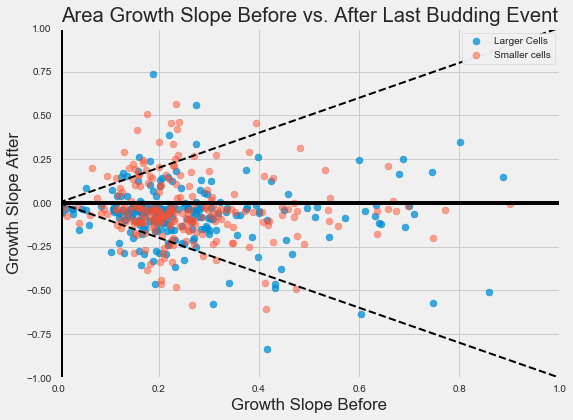

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(large_cells_lin_data56['pre-slope'], large_cells_lin_data56['post-slope'], alpha = .75, label = 'Larger Cells')
plt.scatter(small_cells_lin_data56['pre-slope'], small_cells_lin_data56['post-slope'], alpha = .5, label = 'Smaller cells')
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Area Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=1)
plt.ylim(ymin=-1, ymax=1)

plt.legend(loc='upper right', frameon=True, framealpha=10)

ax.axhline(y=0, color='k')
ax.axvline(x=0.005, color='k')
ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)
ax.plot([0, 3], [0, -3], color='k', linestyle='--', linewidth = 2)

